In [1]:
import IPython

def in_colab():
    try:
        import google.colab
        return True
    except:
        return False

SolutionToTask2 = lambda: IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url='https://colab.research.google.com/drive/13OsSjKyzEyiyLdcKAuK6j_kn7aZ3yzxa?usp=sharing#scrollTo=Kaj-befXgS08' if in_colab() else 'QB41_A01_Classical_Gates_Solutions.ipynb#task2')))
SolutionToTask3 = lambda: IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url='https://colab.research.google.com/drive/13OsSjKyzEyiyLdcKAuK6j_kn7aZ3yzxa?usp=sharing#scrollTo=Mh2tRWVhgS08' if in_colab() else 'QB41_A01_Classical_Gates_Solutions.ipynb#task3')))
SolutionToTask4 = lambda: IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url='https://colab.research.google.com/drive/13OsSjKyzEyiyLdcKAuK6j_kn7aZ3yzxa?usp=sharing#scrollTo=bMYC0HmTgS09' if in_colab() else 'QB41_A01_Classical_Gates_Solutions.ipynb#task4')))
SolutionToTask5 = lambda: IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url='https://colab.research.google.com/drive/13OsSjKyzEyiyLdcKAuK6j_kn7aZ3yzxa?usp=sharing#scrollTo=5umL4uZzgS09' if in_colab() else 'QB41_A01_Classical_Gates_Solutions.ipynb#task5')))
SolutionToTask6 = lambda: IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url='https://colab.research.google.com/drive/13OsSjKyzEyiyLdcKAuK6j_kn7aZ3yzxa?usp=sharing#scrollTo=wsWwY8JZgS09' if in_colab() else 'QB41_A01_Classical_Gates_Solutions.ipynb#task6')))

if in_colab():
    !pip install qiskit[visualization]==0.43.3
    !pip install qiskit-aer

# IBM Challengue: Dynamic Circuits

# *What is the difference between statics and dynamic quantum circuits?*

A quantum circuit is a sequence of quantum operations acting on qubits. In static circuits, none of those operations depend on data produced at run time. Dynamic circuits, on the other hand, incorporate classical processing within the coherence time of the qubits. This means that dynamic circuits can make use of mid-circuit measurements and perform feed-forward operations, using the values produced by measurements to determine what gates to apply next.

# *Does a current quantum computing performing operations perfectly?*

No, it isn't. Due to decoherence, leakage, control errors, material imperfections etc. quantum states will never be in perfect alignment with the intended state. There is a small chance that errors will be introduced, resulting for instance in one of the memory bits changing from 1 to 0. Therefore, we have various methods to perform error correction on quantum states, such as repetition codes.

## *Quantum Error Correction*

To enable real-time quantum error correction (QEC), we require the capability to dynamically control quantum program flow during execution so that quantum gates may be conditioned on measurement results.

In the code below, we will run the bit-flip code, which is a very simple form of QEC, where we encode one logical qubit using three physical qubits. We will demonstrate a dynamic quantum circuit that can protect an encoded qubit from a single bit-flip error.

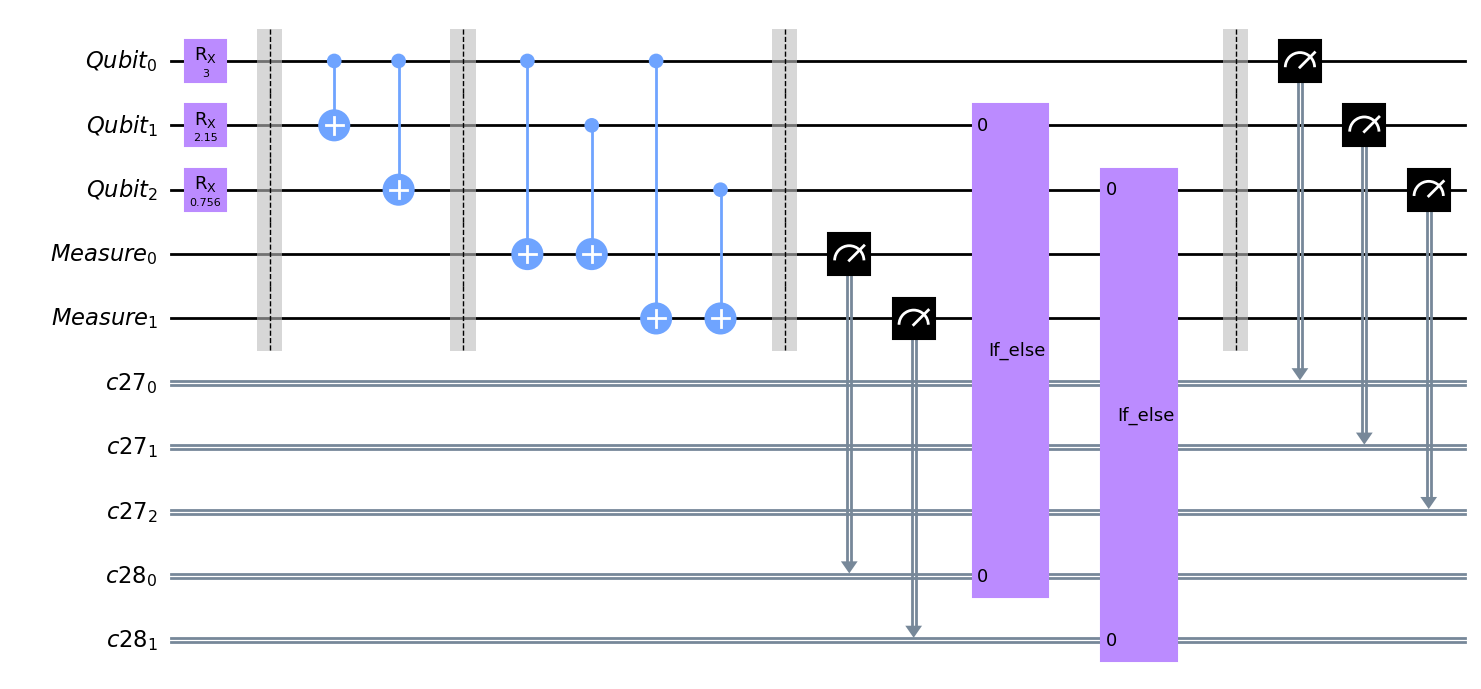

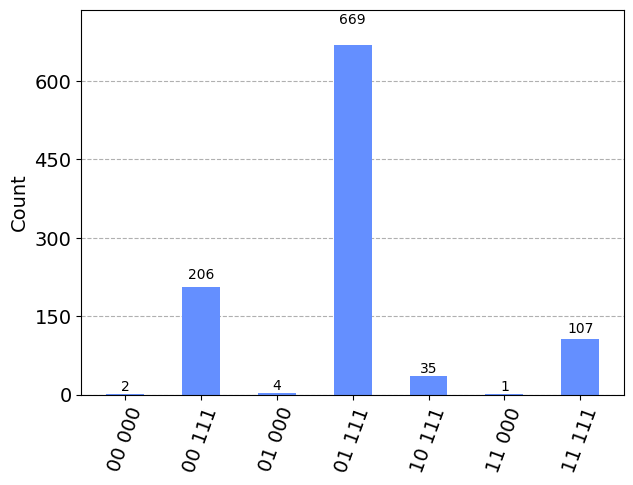

In [11]:
# The code below was designed by Miguel Angel Luna Molinares for QRise IBM challenge
# April, 2024


# Qiskit imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import random
from math import pi, sin, cos


#*******************************************************************************

# WHAT ARE WE GOING TO DO?

# Repetition is one of the easiest ways to prevent and correct errors.
# Instead of using a physical qubit, we encode a logical qubit using three
# physical qubits. Using two extra ancilla bits, single bit-flip errors
# can now be detected and corrected.

qreg_data = QuantumRegister(3,"Qubit") # This quantum register corresponding to data

qreg_measure = QuantumRegister(2,"Measure") # This quantum register corresponding to ancillas

creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)

c = ClassicalRegister(5) # this classical register for all measuremnts

qc = QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome) # a quantum circuit with quantum and classical registers


#*******************************************************************************

# PROBABILISTIC ERROR INTRODUCTION

# Instead of manually introducing errors, we can introduce some errors
# with some probability by using binary controlled rotations.

random_angle_qubit0 = random.uniform(0,pi)
random_angle_qubit1 = random.uniform(0,pi)
random_angle_qubit2 = random.uniform(0,pi)

qc.rx(random_angle_qubit0,qreg_data[0])
qc.rx(random_angle_qubit1,qreg_data[1])
qc.rx(random_angle_qubit2,qreg_data[2])

qc.barrier()

#*******************************************************************************

# ENCODING QUBITS

# The first stage of our repetition code is to encode a single qubit into our
# logical qubit. Using two CNOT-operations, encoding to a logical qubit is done
# from an arbitrary state

qc.cx(qreg_data[0],qreg_data[1])
qc.cx(qreg_data[0],qreg_data[2])

qc.barrier()

#*******************************************************************************

# ERROR DETECTION

# Error-detection is done using the two ancilla qubits. Two CNOT operations are
#coupled with the first ancilla qubit, which is subsequently measured, giving the
# parity of the first two qubits. If we measure 1, we know that in either the first
# or the second qubit an error occurred. Similarly, two CNOT operations are coupled
# with the second ancilla qubit and the first and third qubit. Measuring the second
# ancilla qubit gives the parity between the first and third qubit.
# If we measure 1, we now know that in either the first or third qubit an error occurred.


qc.cx(qreg_data[0],qreg_measure[0])
qc.cx(qreg_data[1],qreg_measure[0])

qc.cx(qreg_data[0],qreg_measure[1])
qc.cx(qreg_data[2],qreg_measure[1])

qc.barrier()

#*******************************************************************************

# ERROR CORRECTION

# Combining measurement results from the ancilla qubits, we can determine in
# which qubit, if any, an error occurred. The combined result of the two parity
# measurements is called the error-syndrome.

# Suppose for example a measurement of the ancillas gives 1 for the first and 0
# for the second ancilla qubit, then we know that an error occurred in the first qubit.
# The error can be corrected by applying a binary controlled X-gate on the qubit.

# Above, we assumed that only a single error occurred. In case two errors occurred,
# we are still able to run the error correcting circuit, however, the wrong bit
# will be corrected. If all bits are flipped, we are not able to detect an error,
# and in fact, we wrongfully assume no error occurred.

# With an error-probability smaller than 0.5 it is more likely that at most a single
# error occurred, than that two or more errors occurred.

# When not applying error correction, measurement of the first three qubits will give
# 010, while applying error correction will result in 000 with the ancilla qubits being
# qubit three 1 and qubit four 0.


qc.measure(qreg_measure, creg_syndrome)

with qc.if_test((creg_syndrome[0], 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(qreg_data[1])

with qc.if_test((creg_syndrome[1], 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(qreg_data[2])

qc.barrier()

qc.measure(qreg_data, creg_data)

#*******************************************************************************

# DISPLAYING CIRCUIT RESULTS

# When we examine the output of the circuit, we have to keep in mind that
# the 3 least significant bit values denote the state of the digital register
# of the data qubits at the end of the code, the next two bits show the state of
# the digital register of the two ancilla qubits and the 3 most significant bits
# that of our error-control qubits.

display(qc.draw(output='mpl', style='iqp'))

from qiskit import Aer

# initialize the simulator
backend_sim = Aer.get_backend("aer_simulator")

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(reset_sim_counts)

# Thanks you for your attention!
